# IMPORT THE PACKAGES NEEEDED

In [1]:
import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers
import keras_tuner as kt
import sklearn
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split


## LOAD ALL THE FILES NEEDED


Steady_state_transients_df---->  DataFrame of examples for both steady state and transients Active Power, Frequency, Voltage, and Reactive Power
Steady_state_transients_df---->  numpy of target for both steady state and transients Active Power, Frequency, Voltage, and Reactive Power

load_changes_incr_dcr_df---->  DataFrame of examples for both incremental and decremental load change- Active Power, Frequency, Voltage, and Reactive Power
load_changes_incr_dcr_df---->  numpy of target for both incremental and decremental load change- Active Power, Frequency, Voltage, and Reactive Power

breaker_opening_df---->  DataFrame of examples for breaker opening :Active Power, Frequency, Voltage, and Reactive Power
breaker_opening_df---->  numpy of target for breaker opening: Active Power, Frequency, Voltage, and Reactive Power

sensor_fault_df---->  DataFrame of examples for sensor fault: Active Power, Frequency, Voltage, and Reactive Power
sensor_fault_df---->  numpy of target for sensor fault: Active Power, Frequency, Voltage, and Reactive Power

stealthy_FDIA_df---->  DataFrame of examples for stealthy FDIA: Active Power, Frequency, Voltage, and Reactive Power
stealthy_FDIA_df---->  numpy of target for stealthy FDIA: Active Power, Frequency, Voltage, and Reactive Power

FDIA_df---->  DataFrame of examples for FDIA: Active Power, Frequency, Voltage, and Reactive Power
FDIA_df---->  numpy of target for FDIA: Active Power, Frequency, Voltage, and Reactive Power

In [2]:
waveform_1 = joblib.load('Steady_state_transients_df')
targets_1 = joblib.load('Steady_state_transients_np')

waveform_2 = joblib.load('load_changes_incr_dcr_df')
targets_2 = joblib.load('load_changes_incr_dcr_np')

waveform_3 = joblib.load('breaker_opening_df')
targets_3 = joblib.load('breaker_opening_np')

waveform_4 = joblib.load('sensor_fault_df')
targets_4 = joblib.load('sensor_fault_np')

waveform_5 = joblib.load('stealthy_FDIA_df')
targets_5 = joblib.load('stealthy_FDIA_np')

waveform_6 = joblib.load('fdia_df.joblib')
targets_6 = joblib.load('fdia.joblib')


# Confirm that every class size is made up of 400 examples

### The integar representing the False data injection attack is represented as 8 but is changed to 7, making the class representations orderly...It is zero indexed

The numpy array to store the target for the FDIA is numbered 8, so that should be changed to 7, to make it easier to learn the model....Class id should follow each other ideally

In [3]:
targets_6[targets_6 == [8]] = [7]

In [4]:
print(np.unique(targets_1, return_counts=True))
print(np.unique(targets_2, return_counts=True))
print(np.unique(targets_3, return_counts=True))
print(np.unique(targets_4, return_counts=True))
print(np.unique(targets_5, return_counts=True))
print(np.unique(targets_6, return_counts=True))

(array([0., 1.]), array([400, 400], dtype=int64))
(array([2., 3.]), array([400, 400], dtype=int64))
(array([4]), array([400], dtype=int64))
(array([5.]), array([400], dtype=int64))
(array([6]), array([400], dtype=int64))
(array([7]), array([400], dtype=int64))


As shown above class 0 to class 7, 8 classes in total all have 400 instances... NOt all unique but each scenarios was simulated at different loads...

## Create a list to contain tuples of the predictors prefixed with `waveform` and targets prefixed with `targets` so that they map to each other....predictor-target pairs for each scenario

In [5]:
all_events = [
    (waveform_1, targets_1), 
    (waveform_2, targets_2), 
    (waveform_3, targets_3), 
    (waveform_4, targets_4), 
    (waveform_5, targets_5), 
    (waveform_6, targets_6),
]


## Create one dataframe to house all the examples of every class or scenario and one numpy array representing the class from 0 to 7
 In the dataframe for all examples, every 1000 samples is an instance

0 - Transient

1- Steady State

2 - Incremental Load change

3 - Decremental load change

4 - Breaker opening

5 - Sensor fault

6 - Stealthy FDIA

7 - FDIA


In [6]:
for i, (power, pred_class) in enumerate(all_events):
    if i == 0:
        building_block = power
        building_arr = pred_class
    else:
        building_block = pd.concat(
            (building_block, power), ignore_index=True, axis=0
        )
        building_arr = np.append(building_arr, pred_class, axis=0)

waveform = building_block
all_targets = building_arr
    

### There are a total of 3_200 instances meaning that there would be 3_200_000 rows in the dataframe capturing all examples: `waveform`

In [7]:
print(waveform.shape, all_targets.shape)
n_instances = all_targets.shape[0]
print(n_instances)

(3200000, 12) (3200, 1)
3200


8 classes * 400 instances which is a total of 3_200 instances

## Confirm once again the class size of each class in the numpy array for all targets `all_targets`

In [8]:
np.unique(all_targets, return_counts=True)

(array([0., 1., 2., 3., 4., 5., 6., 7.]),
 array([400, 400, 400, 400, 400, 400, 400, 400], dtype=int64))

### Create template to organise the shape of the dataframe to hold all the instances synthesized. A multidimensional numpy is used for this....Each is gonna be 1000 by 3, 3 columns for active Power alone in all 3 phases.....This is where the other variables are dropped: Reactive power, Frequency, and voltage

In [9]:
predictors = np.empty(shape=(0, 1000, 3))

In [10]:
start, end = 0, 1
for i in range(n_instances):
    arr = np.array([waveform.iloc[start * 1_000: end * 1_000, 0:3].to_numpy(),])
    predictors = np.append(predictors, arr, axis=0)
    start += 1
    end += 1

### There are 3_200 total instances, each have a dimension of 1_000 samples in 0.5 seconds for Active power in 3 lines

In [11]:
predictors.shape

(3200, 1000, 3)

## Use the test_train_split function imported to split the dataset into training and testing pairs, 30 percent for testing and 70 percent for training  

In [12]:
X_train, X_test, y_train, y_test = train_test_split(predictors, all_targets, test_size=0.3, random_state=42)

### The `model_builder` function is to create the sequental model: two series of convolutions each followed by one pooling layer, the cnn is then fed into fully connected layers

In [13]:
def model_builder(hp):
    model = keras.Sequential()
    #######################################
    n_filters_1 = hp.Int('n_filters_convlayer1', min_value = 4, max_value=200, step=4)
    kernel_1 = hp.Int('Kernel_convlayer_1', min_value=1, max_value=4, step=1)
    padding_1 = hp.Choice('padding_1', values=['valid', 'same', 'causal'])
    strides_1 = hp.Choice('strides_1', values=[1, 2, 3])
    n_filters_2 = hp.Int('n_filters_convlayer2', min_value = 4, max_value=200, step=4)
    kernel_2 = hp.Int('Kernel_convlayer_2', min_value=1, max_value=4, step=1)
    padding_2 = hp.Choice('padding_2', values=['valid', 'same', 'causal'])
    strides_2 = hp.Choice('strides_2', values=[1, 2,])
    n_filters_3 = hp.Int('n_filters_convlayer3', min_value = 4, max_value=200, step=4)
    kernel_3 = hp.Int('Kernel_convlayer_3', min_value=1, max_value=4, step=1)
    padding_3 = hp.Choice('padding_3', values=['valid', 'same', 'causal'])
    strides_3 = hp.Choice('strides_3', values=[1, 2,])
    pool_1 = hp.Int('pool_1', min_value=2, max_value=4, step=1)
    pool_2 = hp.Int('pool_2', min_value=2, max_value=8, step=1)
    #####################################################################
    n_filters_4 = hp.Int('n_filters_convlayer4', min_value = 4, max_value=200, step=4)
    kernel_4 = hp.Int('Kernel_convlayer_4', min_value=1, max_value=4, step=1)
    padding_4 = hp.Choice('padding_4', values=['valid', 'same', 'causal'])
    strides_4 = hp.Choice('strides_4', values=[1, 2,])
    n_filters_5 = hp.Int('n_filters_convlayer5', min_value = 4, max_value=200, step=4)
    kernel_5 = hp.Int('Kernel_convlayer_5', min_value=1, max_value=4, step=1)
    padding_5 = hp.Choice('padding_5', values=['valid', 'same', 'causal'])
    strides_5 = hp.Choice('strides_5', values=[1, 2, ])
    n_filters_6 = hp.Int('n_filters_convlayer6', min_value = 4, max_value=200, step=4)
    kernel_6 = hp.Int('Kernel_convlayer_6', min_value=1, max_value=4, step=1)
    padding_6 = hp.Choice('padding_6', values=['valid', 'same', 'causal'])
    strides_6 = hp.Choice('strides_6', values=[1, 2, ])
    n_filters_7 = hp.Int('n_filters_convlayer7', min_value = 4, max_value=200, step=4)
    kernel_7 = hp.Int('Kernel_convlayer_7', min_value=1, max_value=3, step=1)
    padding_7 = hp.Choice('padding_7', values=['valid', 'same', 'causal'])
    strides_7 = hp.Choice('strides_7', values=[1, 2, 3,])
    ###################################################################
    model.add(layers.Conv1D(filters=n_filters_1, kernel_size=(kernel_1), activation='relu', input_shape=(1000, 3), padding=padding_1, strides=strides_1))
    model.add(layers.Conv1D(filters=n_filters_2, kernel_size=(kernel_2), activation='relu', padding=padding_2, strides=strides_2))
    model.add(layers.Conv1D(filters=n_filters_3, kernel_size=(kernel_3), activation='relu', padding=padding_3, strides=strides_3))
    model.add(layers.MaxPooling1D((pool_1)))
    #################################################
    model.add(layers.Conv1D(n_filters_4, (kernel_4), activation='relu', input_shape=(1000, 3), padding=padding_4, strides=strides_4))
    model.add(layers.Conv1D(n_filters_5, (kernel_5), activation='relu', padding=padding_5, strides=strides_5))
    model.add(layers.Conv1D(n_filters_6, (kernel_6), activation='relu', padding=padding_6, strides=strides_6))
    model.add(layers.Conv1D(n_filters_7, (kernel_7), activation='relu', padding=padding_7, strides=strides_7))
    model.add(layers.MaxPooling1D((pool_2)))


    ####################################
    dense_nodes_1 = hp.Int('nodes_dense_1', min_value=4, max_value=512, step=16)
    activation_1 = hp.Choice('Activation_layer_1', values=['relu', 'Softmax', 'sigmoid'])
    dense_nodes_2 = hp.Int('nodes_dense_2', min_value=4, max_value=512, step=16)
    activation_2 = hp.Choice('Activation_layer_2', values=['relu', 'Softmax', 'sigmoid'])
    dense_nodes_3 = hp.Int('nodes_dense_3', min_value=4, max_value=512, step=16)
    activation_3 = hp.Choice('Activation_layer_3', values=['relu', 'Softmax', 'sigmoid'])
    model.add(layers.Flatten())
    model.add(layers.Dense(units=dense_nodes_1, activation=activation_1))
    model.add(layers.Dense(units=dense_nodes_2, activation=activation_2))
    model.add(layers.Dense(units=dense_nodes_3, activation=activation_3))
    model.add(layers.Dense(8))

    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

    
    return model

### create the Hyperband hyperparameter tuning job

In [14]:
location = r'C:\Users\chigo\OneDrive\Desktop\final_truth\Dissertation_2023_ucc_chigozie',
import keras_tuner as kt
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=30,
                     factor=3,
            directory=location
                     project_name='microgrid_project_1')


### Perform Hyperband hyperparameter tuning

In [15]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
tuner.search(X_train, y_train, epochs=25,  validation_split=0.3, callbacks=[stop_early])

best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]




Trial 73 Complete [00h 02m 36s]
val_accuracy: 0.757440447807312

Best val_accuracy So Far: 0.875
Total elapsed time: 00h 26m 36s
INFO:tensorflow:Oracle triggered exit


In [17]:
print(
    f"Convlayer 1 filters {best_hps.get('n_filters_convlayer1')} ",
    f"Convlayer 1 kernel size {best_hps.get('Kernel_convlayer_1')} ",
    f"Convlayer 1 padding  {best_hps.get('padding_1')} ",
)
print(
    "Convlayer 2 filters {best_hps.get('n_filters_convlayer2')} ",
    f"Convlayer 2 kernel size {best_hps.get('Kernel_convlayer_2')} ",
    f"Convlayer 2 padding  {best_hps.get('padding_2')} ",
)
print(
    f"Convlayer 3 filters {best_hps.get('n_filters_convlayer3')} ",
    f"Convlayer 3 kernel size {best_hps.get('Kernel_convlayer_3')} ",
    f"Convlayer 3 padding  {best_hps.get('padding_3')} ",
)
print(
    f"Convlayer 4 filters {best_hps.get('n_filters_convlayer4')} ",
    f"Convlayer 4 kernel size {best_hps.get('Kernel_convlayer_4')} ",
    f"Convlayer 4 padding  {best_hps.get('padding_4')} ",
)
print(
    f"Convlayer 5 filters {best_hps.get('n_filters_convlayer5')} ",
    f"Convlayer 5 kernel size {best_hps.get('Kernel_convlayer_5')} ",
    f"Convlayer 5 padding  {best_hps.get('padding_5')} ",
)
print(
    f"Convlayer 6 filters {best_hps.get('n_filters_convlayer6')} ",
    f"Convlayer 6 kernel size {best_hps.get('Kernel_convlayer_6')} ",
    f"Convlayer 6 padding  {best_hps.get('padding_6')} ",
)
print(
    f"Convlayer 7 filters {best_hps.get('n_filters_convlayer7')} ",
    f"Convlayer 7 kernel size {best_hps.get('Kernel_convlayer_7')} ",
    f"Convlayer 7 padding  {best_hps.get('padding_7')} ",
)
print(
    f"first pooling size {best_hps.get('pool_1')}",
    f"Second pooling size {best_hps.get('pool_2')}",
)
print(
    f"Dense layer 1 nodes is: {best_hps.get('nodes_dense_1')} activation {best_hps.get('Activation_layer_1')}",
    f"Dense layer 2 nodes is: {best_hps.get('nodes_dense_2')} activation {best_hps.get('Activation_layer_2')}",
    f"Dense layer 3 nodes is: {best_hps.get('nodes_dense_3')} activation {best_hps.get('Activation_layer_3')}",
)

Convlayer 1 filters 188  Convlayer 1 kernel size 2  Convlayer 1 padding  causal 
Convlayer 2 filters {best_hps.get('n_filters_convlayer2')}  Convlayer 2 kernel size 2  Convlayer 2 padding  causal 
Convlayer 3 filters 20  Convlayer 3 kernel size 3  Convlayer 3 padding  same 
Convlayer 4 filters 116  Convlayer 4 kernel size 2  Convlayer 4 padding  valid 
Convlayer 5 filters 40  Convlayer 5 kernel size 1  Convlayer 5 padding  valid 
Convlayer 6 filters 4  Convlayer 6 kernel size 3  Convlayer 6 padding  causal 
Convlayer 7 filters 24  Convlayer 7 kernel size 2  Convlayer 7 padding  same 
first pooling size 3 Second pooling size 4
Dense layer 1 nodes is: 484 activation relu Dense layer 2 nodes is: 356 activation relu Dense layer 3 nodes is: 468 activation relu


# RETRAIN MODEL BASED ON LEARNED BEST HPs

In [21]:
model = tuner.hypermodel.build(best_hps)
history = model.fit(X_train, y_train, epochs=25, validation_split=0.2)

val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))


Epoch 1/25
56/56 [==============================] - 3s 35ms/step - loss: 1.6562 - accuracy: 0.4074 - val_loss: 1.1016 - val_accuracy: 0.5112
Epoch 2/25
56/56 [==============================] - 2s 35ms/step - loss: 1.0007 - accuracy: 0.5871 - val_loss: 0.8738 - val_accuracy: 0.6183
Epoch 3/25
56/56 [==============================] - 2s 33ms/step - loss: 0.8083 - accuracy: 0.6646 - val_loss: 0.7806 - val_accuracy: 0.6094
Epoch 4/25
56/56 [==============================] - 2s 35ms/step - loss: 0.8126 - accuracy: 0.6618 - val_loss: 0.6882 - val_accuracy: 0.7612
Epoch 5/25
56/56 [==============================] - 2s 34ms/step - loss: 0.7690 - accuracy: 0.6657 - val_loss: 0.7396 - val_accuracy: 0.6004
Epoch 6/25
56/56 [==============================] - 2s 34ms/step - loss: 0.6303 - accuracy: 0.7327 - val_loss: 0.5317 - val_accuracy: 0.7946
Epoch 7/25
56/56 [==============================] - 2s 34ms/step - loss: 0.6286 - accuracy: 0.7288 - val_loss: 0.5184 - val_accuracy: 0.7924
Epoch 8/25
56

# The number of epochs that gave the best highest validation accuracy

In [22]:
best_epoch

23


# Retrain Model using that optimal number of epochs

In [23]:
hypermodel = tuner.hypermodel.build(best_hps)

# Retrain the model
hypermodel.fit(X_train, y_train, epochs=best_epoch, validation_split=0.2)


Epoch 1/23
56/56 [==============================] - 4s 40ms/step - loss: 3.9480 - accuracy: 0.2796 - val_loss: 1.3735 - val_accuracy: 0.3728
Epoch 2/23
56/56 [==============================] - 2s 35ms/step - loss: 1.2195 - accuracy: 0.4967 - val_loss: 0.9786 - val_accuracy: 0.6942
Epoch 3/23
56/56 [==============================] - 2s 35ms/step - loss: 0.8348 - accuracy: 0.6451 - val_loss: 0.6858 - val_accuracy: 0.7009
Epoch 4/23
56/56 [==============================] - 2s 34ms/step - loss: 0.6300 - accuracy: 0.7316 - val_loss: 0.4585 - val_accuracy: 0.8237
Epoch 5/23
56/56 [==============================] - 2s 34ms/step - loss: 0.5504 - accuracy: 0.7746 - val_loss: 0.4937 - val_accuracy: 0.7634
Epoch 6/23
56/56 [==============================] - 2s 34ms/step - loss: 0.5432 - accuracy: 0.7584 - val_loss: 0.3973 - val_accuracy: 0.8326
Epoch 7/23
56/56 [==============================] - 2s 34ms/step - loss: 0.6411 - accuracy: 0.7556 - val_loss: 0.4544 - val_accuracy: 0.8259
Epoch 8/23
56

# MODEL SUMMARY

In [24]:
hypermodel.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_28 (Conv1D)          (None, 334, 188)          1316      
                                                                 
 conv1d_29 (Conv1D)          (None, 167, 68)           25636     
                                                                 
 conv1d_30 (Conv1D)          (None, 84, 20)            4100      
                                                                 
 max_pooling1d_8 (MaxPoolin  (None, 28, 20)            0         
 g1D)                                                            
                                                                 
 conv1d_31 (Conv1D)          (None, 27, 116)           4756      
                                                                 
 conv1d_32 (Conv1D)          (None, 27, 40)            4680      
                                                      

## EVALUTAE BASED ON ACCURACY ALONE

In [26]:
eval_result = hypermodel.evaluate(X_test, y_test)
print("[test loss, test accuracy]:", eval_result)


30/30 [==============================] - 0s 13ms/step - loss: 0.2878 - accuracy: 0.8438
[test loss, test accuracy]: [0.2878144383430481, 0.84375]


# Plot the training history of the model: the `hypermodel`

30/30 - 0s - loss: 0.2878 - accuracy: 0.8438 - 373ms/epoch - 12ms/step


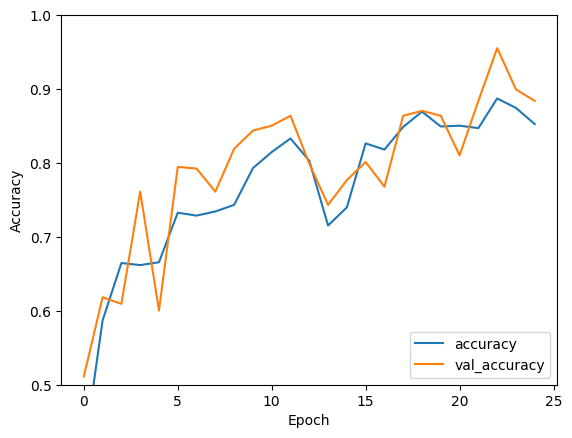

In [27]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = hypermodel.evaluate(X_test,  y_test, verbose=2)

In [28]:
y_preds = hypermodel.predict(X_test)
y_true = y_test

30/30 [==============================] - 0s 12ms/step


In [29]:
all_y_preds = y_preds.argmax(axis=1)

In [30]:
y_preds = np.array([[val] for val in all_y_preds])

In [31]:
print(classification_report(y_pred=y_preds, y_true=y_true, ))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       135
         1.0       0.00      0.00      0.00       126
         2.0       1.00      0.88      0.94       118
         3.0       0.98      0.92      0.95       119
         4.0       0.92      1.00      0.96       114
         5.0       1.00      1.00      1.00       130
         6.0       0.43      1.00      0.60       104
         7.0       1.00      1.00      1.00       114

    accuracy                           0.84       960
   macro avg       0.79      0.85      0.81       960
weighted avg       0.80      0.84      0.81       960



c:\Users\chigo\anaconda3\envs\project\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\chigo\anaconda3\envs\project\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\chigo\anaconda3\envs\project\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [32]:
all_labels = [
    'Steady State', 'Transients', 
    'Incremental load change', 
    'Decremental load change', 
    'Breaker opening', 'Sensor fault', 
    'Stealthy fdia', 'FDIA'
    ]

# CONFUSION MATRIX

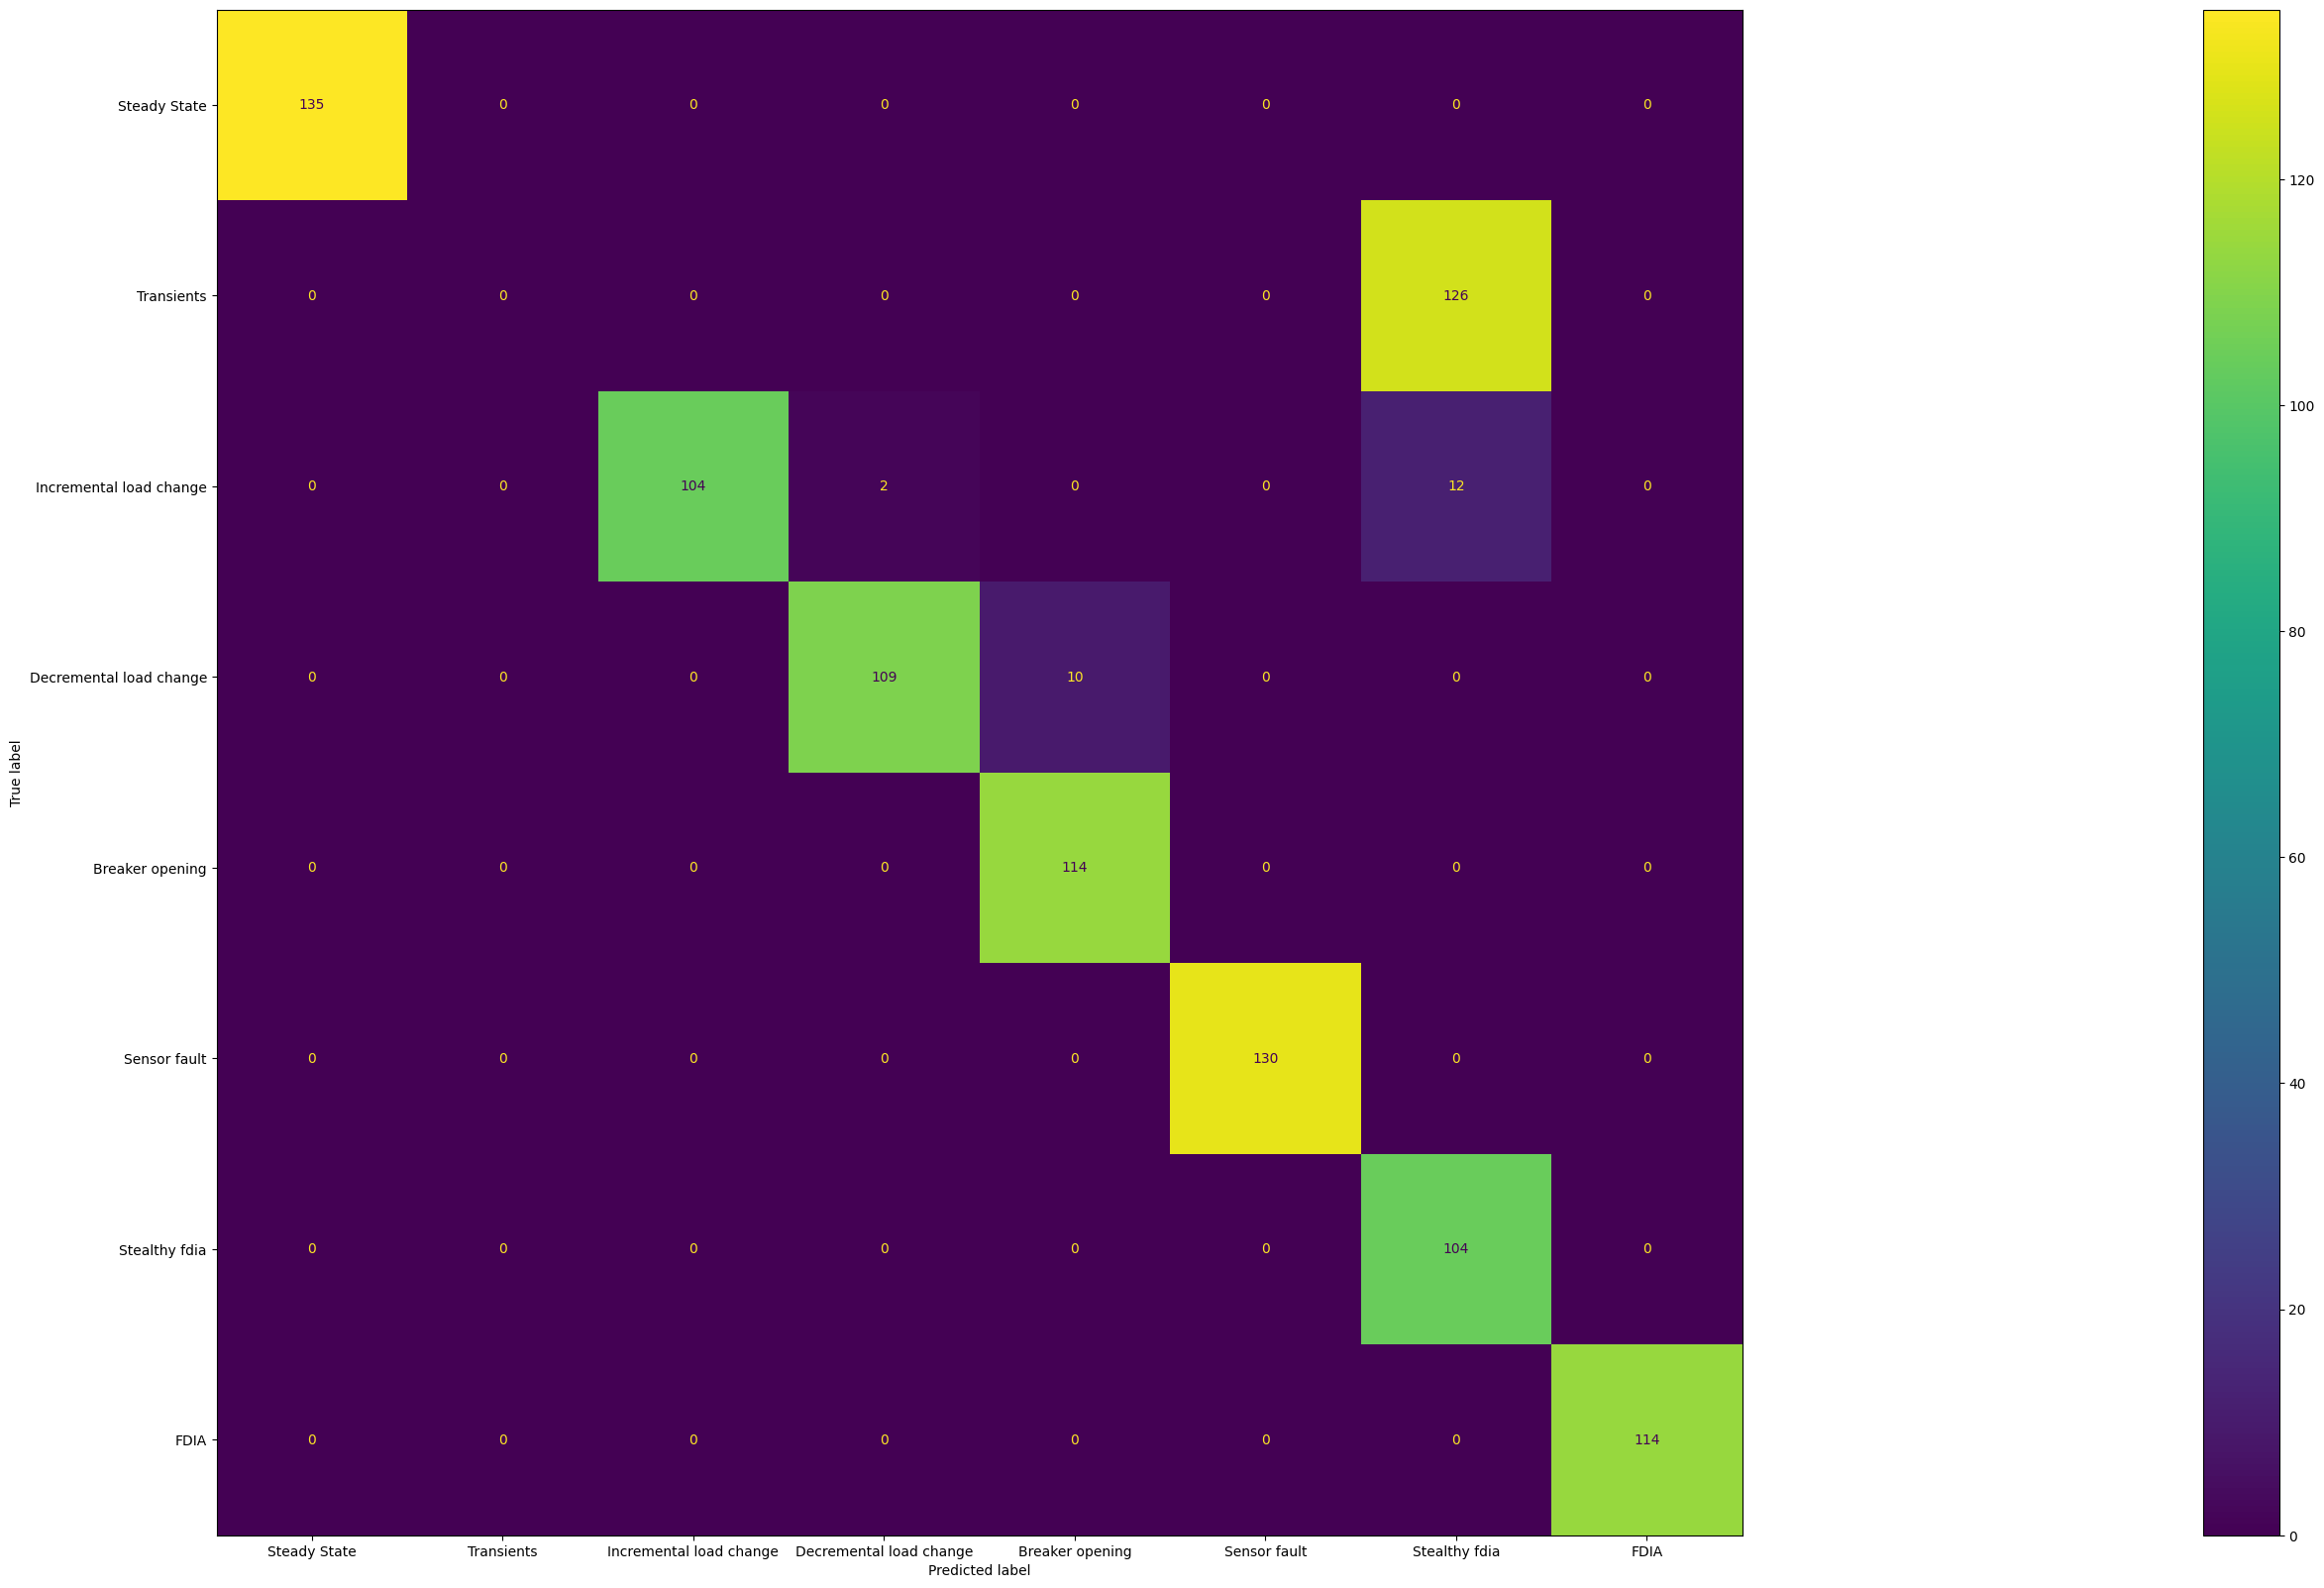

In [33]:
fig, ax = plt.subplots(figsize=(120,20))
cm = confusion_matrix(y_true, y_preds, labels=[0, 1, 2, 3, 4, 5, 6, 7])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=all_labels,)

disp.plot(ax=ax)

# SAVE THE DEVELOPED MODEL FOR FUTURE USE

In [35]:
joblib.dump("hypermodel", "cnn_model.joblib")

['cnn_model.joblib']